In [1]:
import pandas as pd

# from http://nlp.cs.washington.edu/zeroshot/evaluate.py
import os
import codecs
import re
from itertools import groupby
import string
import sys
import numpy as np

PUNCTUATION = set(string.punctuation)

def eval_zero_re(test_file, answer_file):
    q_aprf = read_results(test_file, answer_file)
    return pretify(q_aprf)

def read_results(test_set, answer_file):
    with codecs.open(test_set, 'r', 'utf-8') as fin:
        data = [line.strip().split('\t') for line in fin]
    metadata = [x[:4] for x in data]
    gold = [set(x[4:]) for x in data]

    new_gold = []
    for g in gold:
        if len(g) > 0:
            new_gold.append(g)

    with codecs.open(answer_file, 'r', 'utf-8') as fin:
        answers = [line.strip() for line in fin]

    new_answers = answers[1:]

    telemetry = []
    for m, g, a in zip(metadata, new_gold, new_answers):
        stats = score_fn(g, a)
        telemetry.append([m[0], m[1], str(len(g) > 0), stats])
    return aprf(telemetry)


def parse_no_answers(results):
    p_answer = [a for i, a in sorted([(int(i), a) for i, a in results[0]['scores'].items()])]
    p_no_answer = [a for i, a in sorted([(int(i), a) for i, a in results[0]['na'].items()])]

    import numpy as np
    return [answer > no_answer for answer, no_answer in zip(p_answer, p_no_answer)]


def gb(collection, keyfunc):
    return [(k, list(g)) for k, g in groupby(sorted(collection, key=keyfunc), keyfunc)]


def aprf(g):
    tp, tn, sys_pos, real_pos = sum(map(lambda x: x[-1], g))
    total = len(g)
    # a = float(tp + tn) / total
    # nr = tn / float(total - real_pos)
    # npr = tn / float(total - sys_pos)
    if tp == 0:
        p = r = f = 0.0
    else:
        p = tp / float(sys_pos)
        r = tp / float(real_pos)
        f = 2 * p * r / (p + r)
    # return np.array((a, p, r, f, npr, nr))
    return np.array((p, r, f))


def score_fn(gold, answer):
    if len(gold) > 0:
        gold = set.union(*[simplify(g) for g in gold])
    answer = simplify(answer)
    result = np.zeros(4)
    if answer == gold:
        if len(gold) > 0:
            result[0] += 1
        else:
            result[1] += 1
    if len(answer) > 0:
        result[2] += 1
    if len(gold) > 0:
        result[3] += 1
    return result


def simplify(answer):
    return set(''.join(c for c in t if c not in PUNCTUATION) for t in answer.strip().lower().split()) - {'the', 'a', 'an', 'and', ''}


def pretify(results):
    return ' \t '.join([': '.join((k, v)) for k, v in zip(['Precision', 'Recall', 'F1'], map(lambda r: '{0:.2f}%'.format(r*100), results))])

In [3]:
def preprocess_the_prediction_files(main_path, list_of_files):
    for file in list_of_files:
        df = pd.read_csv(os.path.join(main_path, file), sep=',')
        df["predictions_str"].to_csv(os.path.join("/tmp/", file), sep='\t', header=True, index=False)

def eval_the_prediction_files(list_of_files, gold_file):
    scores = {}
    scores_list = []
    for file in list_of_files:
        score = eval_zero_re(gold_file, os.path.join("/tmp/", file))
        scores[score] = file
        scores_list.append(score)
    return scores, scores_list
        

In [15]:
# GOLD Predictions on the dev 1 fold 1.
fold_files = ["gold_fold_1.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(0, 132, 1)]
fold_files.append("gold_fold_1.dev.predictions.0.full.csv")
fold_files.extend(["gold_fold_1.dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 132, 1)])
fold_files.append("gold_fold_1.dev.predictions.1.full.csv")
fold_0_path = "~/gold_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
fold_0_gold_f1_dict = {float(row.split()[-1][0:-1]): row for row in fold_0_gold_scores.keys()}
max_f1_gold_0 = max(fold_0_gold_f1_dict.keys())
print(fold_0_gold_f1_dict[max_f1_gold_0])
print(fold_0_gold_scores[fold_0_gold_f1_dict[max_f1_gold_0]])

[40.72, 53.22, 51.25, 53.53, 50.4, 50.11, 51.81, 51.78, 55.67, 50.46, 46.48, 49.0, 42.7, 47.66, 47.41, 45.59, 44.3, 51.36, 46.56, 49.21, 46.6, 41.39, 48.52, 36.95, 52.47, 48.94, 44.86, 43.05, 47.75, 39.19, 37.89, 42.11, 44.36, 38.7, 45.51, 38.96, 47.53, 34.8, 38.53, 43.12, 39.3, 39.29, 38.85, 49.9, 46.15, 40.8, 42.6, 43.41, 40.08, 40.42, 38.91, 41.43, 44.53, 43.2, 36.28, 38.22, 37.09, 43.84, 36.05, 38.32, 38.98, 38.67, 37.25, 38.98, 34.48, 37.09, 37.42, 40.56, 39.68, 36.0, 42.0, 40.41, 42.75, 43.76, 40.96, 42.35, 41.94, 42.4, 40.82, 40.83, 40.0, 37.64, 39.59, 38.48, 40.32, 40.5, 35.51, 42.54, 40.57, 40.48, 37.38, 36.99, 33.85, 37.11, 35.04, 37.76, 30.43, 33.85, 33.56, 34.39, 35.95, 40.48, 36.14, 40.67, 36.96, 38.25, 39.01, 37.3, 37.95, 36.03, 39.53, 32.67, 33.06, 31.12, 36.15, 33.0, 31.42, 28.57, 33.33, 31.91, 33.95, 37.05, 30.84, 36.73, 37.55, 36.44, 36.4, 36.51, 38.33, 38.16, 38.49, 38.52, 40.0, 33.27, 36.09, 37.66, 38.08, 39.55, 36.55, 39.05, 35.93, 40.71, 43.41, 37.08, 38.79, 36.51

In [8]:
# GOLD Predictions on the dev 1 fold 1.
fold_files = ["gold_fold_1.test.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 132, 1)]
#fold_files.append("gold_fold_1.test.predictions.0.full.csv")
fold_0_path = "~/gold_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/test.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
#fold_0_gold_f1_dict = {float(row.split()[-1][0:-1]): row for row in fold_0_gold_scores.keys()}
#max_f1_gold_0 = max(fold_0_gold_f1_dict.keys())
#print(fold_0_gold_f1_dict[max_f1_gold_0])
#print(fold_0_gold_scores[fold_0_gold_f1_dict[max_f1_gold_0]])

[66.27, 65.0, 64.69, 63.98, 62.7, 64.73, 60.6, 64.29, 62.74, 61.91, 61.73, 62.61, 63.93, 64.2, 59.19, 60.9, 62.88, 60.62, 61.5, 63.31, 60.96, 64.14, 54.75, 61.92, 63.44, 59.55, 61.01, 58.36, 59.05, 62.32, 60.26, 60.85, 60.97, 59.67, 61.54, 59.26, 59.74, 59.31, 58.67, 59.89, 61.08, 62.24, 62.69, 60.59, 60.63, 61.8, 60.0, 61.21, 61.08, 59.3, 60.15, 60.65, 59.9, 59.97, 60.17, 61.15, 62.54, 59.87, 59.89, 60.55, 58.18, 58.74, 60.31, 57.27, 58.18, 59.49, 58.48, 60.47, 59.68, 59.21, 60.09, 59.52, 58.91, 59.29, 59.68, 59.46, 59.1, 59.53, 59.39, 58.42, 59.42, 60.11, 57.86, 62.03, 61.18, 58.49, 59.25, 60.71, 60.96, 60.01, 59.24, 57.48, 59.29, 58.68, 61.11, 58.83, 58.56, 56.03, 59.44, 59.19, 60.45, 58.8, 59.31, 60.1, 58.14, 58.91, 59.47, 57.43, 57.46, 61.11, 58.17, 60.52, 57.35, 59.73, 58.33, 58.08, 58.8, 57.13, 55.37, 58.06, 58.78, 57.95, 57.88, 59.04, 58.9, 59.82, 60.83, 58.85, 59.88, 58.44, 57.95]


In [14]:
# GOLD Predictions on the dev 1 fold 1.
fold_files = ["gold_fold_1.test.predictions.0.step.800.csv"]
fold_0_path = "~/gold_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/test.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores_test, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
print(fold_0_gold_scores_test)

{'Precision: 62.43% \t Recall: 66.25% \t F1: 64.28%': 'gold_fold_1.test.predictions.0.step.800.csv'}


In [13]:
# Concat Predictions on the dev 1 fold 1.
fold_files = ["concat_fold_1.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(0, 132, 1)]
fold_files.append("concat_fold_1.dev.predictions.0.full.csv")
fold_files.extend(["concat_fold_1.dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 132, 1)])
fold_files.append("concat_fold_1.dev.predictions.1.full.csv")
fold_0_path = "~/concat_fold_1/"
fold_0_concat_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_concat_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_concat_file)
concat_f1s = []
for score in scores_list:
    score_num = float(score.split()[-1][0:-1])
    concat_f1s.append(score_num)

fold_1_concat_f1s = np.array(concat_f1s)
print(concat_f1s)
fold_0_concat_f1_dict = {float(row.split()[-1][0:-1]): row for row in fold_0_concat_scores.keys()}
max_f1_concat_0 = max(fold_0_concat_f1_dict.keys())
print(fold_0_concat_f1_dict[max_f1_concat_0])
print(fold_0_concat_scores[fold_0_concat_f1_dict[max_f1_concat_0]])

[26.14, 56.35, 56.25, 47.44, 49.69, 48.54, 48.59, 49.21, 48.79, 51.8, 47.04, 47.76, 43.64, 45.49, 46.06, 40.48, 41.72, 45.83, 46.43, 42.65, 48.21, 42.35, 46.39, 38.98, 44.49, 51.72, 42.95, 50.0, 47.4, 35.7, 44.44, 48.02, 43.41, 38.56, 41.0, 33.11, 48.12, 45.49, 37.88, 40.57, 44.98, 41.41, 45.45, 51.27, 52.22, 42.47, 47.77, 44.4, 39.67, 41.58, 38.75, 40.61, 39.85, 43.44, 37.52, 37.79, 39.83, 45.26, 41.45, 37.02, 33.41, 38.0, 35.11, 42.17, 35.5, 39.6, 32.52, 34.95, 37.71, 34.4, 40.56, 36.26, 39.58, 37.04, 40.61, 37.32, 43.44, 32.85, 35.24, 37.96, 32.42, 28.82, 35.67, 31.19, 36.02, 36.07, 33.26, 30.48, 34.66, 37.5, 38.24, 35.73, 33.69, 34.85, 31.97, 31.33, 38.48, 32.72, 29.18, 35.22, 36.59, 38.65, 40.45, 38.13, 36.73, 38.49, 34.47, 26.51, 30.26, 33.06, 32.96, 26.3, 33.21, 29.26, 28.57, 29.69, 28.94, 27.89, 28.25, 35.85, 33.33, 30.77, 38.23, 34.97, 35.7, 38.39, 35.11, 35.59, 35.86, 34.71, 35.88, 36.54, 36.71, 33.61, 36.84, 31.47, 35.36, 33.92, 32.67, 35.99, 37.34, 36.94, 38.19, 34.86, 34.8

In [9]:
# Concat Predictions on the dev 1 fold 1.
fold_files = ["concat_fold_1.test.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 132, 1)]
fold_0_path = "~/concat_fold_1/"
fold_0_concat_file = "./zero-shot-extraction/relation_splits/test.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_concat_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_concat_file)
concat_f1s = []
for score in scores_list:
    score_num = float(score.split()[-1][0:-1])
    concat_f1s.append(score_num)

test_fold_1_concat_f1s = np.array(concat_f1s)
print(concat_f1s)
#fold_0_concat_f1_dict = {float(row.split()[-1][0:-1]): row for row in fold_0_concat_scores.keys()}
#max_f1_concat_0 = max(fold_0_concat_f1_dict.keys())
#print(fold_0_concat_f1_dict[max_f1_concat_0])
#print(fold_0_concat_scores[fold_0_concat_f1_dict[max_f1_concat_0]])

[58.06, 56.83, 54.56, 55.7, 57.31, 57.18, 57.93, 58.24, 56.74, 56.12, 57.99, 55.89, 56.32, 57.98, 56.59, 55.37, 58.61, 55.01, 53.41, 56.27, 53.1, 54.67, 52.79, 54.8, 54.44, 52.94, 55.71, 55.46, 48.49, 52.79, 57.23, 54.0, 55.47, 53.31, 53.83, 53.67, 55.88, 52.68, 55.22, 53.11, 56.1, 58.1, 54.79, 55.7, 55.16, 55.11, 55.09, 54.45, 52.29, 53.96, 54.64, 53.66, 53.77, 54.8, 51.01, 53.53, 54.25, 56.96, 52.56, 55.07, 55.19, 55.38, 54.11, 54.59, 54.51, 51.94, 55.12, 52.94, 54.89, 53.96, 53.8, 55.22, 52.72, 52.29, 53.77, 51.59, 54.73, 50.88, 52.4, 50.69, 50.17, 54.52, 53.04, 54.59, 54.22, 49.72, 51.28, 51.71, 52.0, 53.71, 51.35, 51.27, 50.44, 50.57, 55.02, 53.5, 52.6, 50.63, 50.93, 50.36, 55.49, 55.21, 54.74, 54.81, 51.32, 51.55, 52.24, 46.59, 47.94, 50.9, 46.41, 51.5, 46.09, 49.87, 52.41, 48.77, 49.25, 51.6, 49.85, 51.86, 51.66, 50.12, 50.14, 50.23, 52.66, 48.6, 51.75, 49.23, 51.16, 50.67, 49.71]


In [12]:
# Concat Predictions on the dev 1 fold 1.
fold_files = ["concat_fold_1.test.predictions.0.step.100.csv"]
fold_0_path = "~/concat_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/test.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_concat_scores_test, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
print(fold_0_concat_scores_test)

{'Precision: 60.45% \t Recall: 55.82% \t F1: 58.04%': 'concat_fold_1.test.predictions.0.step.100.csv'}


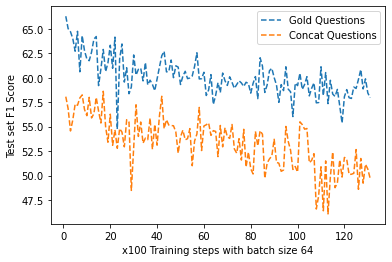

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = [i+1 for i in range(len(test_fold_1_gold_f1s))]

plt.plot(x, test_fold_1_gold_f1s, '--', label="Gold Questions")
plt.plot(x, test_fold_1_concat_f1s, '--', label="Concat Questions")
plt.legend()
plt.ylabel('Test set F1 Score')
plt.xlabel('x100 Training steps with batch size 64')
plt.show()

In [3]:
fold_files = ["base.dev.predictions.0.step.0.csv"]
fold_0_path = "~/mml_mml_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[36.68]
36.68


In [10]:
fold_files = ["mml.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 10, 1)]
fold_0_path = "~/mml_mml_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[40.57, 41.51, 39.71, 40.82, 40.35, 39.41, 35.05, 36.31, 35.94]
38.852222222222224


In [9]:
fold_files = ["gold_base.dev.predictions.0.step.0.csv"]
fold_0_path = "~/mml_mml_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[40.75]
40.75


In [15]:
fold_files = ["pgg.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 10, 1)]
fold_0_path = "~/pgg_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[47.83, 51.76, 51.14, 49.44, 51.94, 48.52, 47.26, 44.2, 43.8]
48.43222222222223


In [18]:
fold_files = ["gold_fold_1.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "~/gold_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[51.24, 52.28, 51.41, 47.33, 49.54, 48.46, 42.23, 50.59, 48.25, 53.54]
49.487


In [20]:
fold_files = ["concat_fold_1.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 5, 1)]
fold_0_path = "~/concat_fold_1/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[50.33, 53.33, 45.76, 53.38]
50.699999999999996


In [30]:
fold_files = ["mml_mml.dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "~/mml_mml_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[51.54, 50.92, 51.29, 50.76, 48.59, 49.5, 49.16, 51.48, 48.15, 50.82]
50.221


In [27]:
fold_files = ["base.dev.predictions.0.step.0.csv"]
fold_0_path = "~/mml_mml_tune_2/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[31.44]
31.44


In [36]:
fold_files = ["pgg_2.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 8, 1)]
fold_0_path = "~/pgg_tune_2/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[44.91, 47.32, 50.5, 49.34, 47.06, 45.44, 41.91]
46.64


In [40]:
import torch
a = torch.rand(4,).view(-1, 1)
print(a)

b = a.repeat(1, 8)

print(b)

tensor([[0.8259],
        [0.6112],
        [0.2291],
        [0.1827]])
tensor([[0.8259, 0.8259, 0.8259, 0.8259, 0.8259, 0.8259, 0.8259, 0.8259],
        [0.6112, 0.6112, 0.6112, 0.6112, 0.6112, 0.6112, 0.6112, 0.6112],
        [0.2291, 0.2291, 0.2291, 0.2291, 0.2291, 0.2291, 0.2291, 0.2291],
        [0.1827, 0.1827, 0.1827, 0.1827, 0.1827, 0.1827, 0.1827, 0.1827]])


In [4]:
fold_files = ["mml_off_policy.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "./mml_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[43.67, 42.0, 43.67, 49.0, 46.0, 45.33, 41.33, 45.33, 45.67, 43.67]
44.56700000000001


In [6]:
fold_files = ["mml_on_policy.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "./mml_tune_on_policy/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[42.67, 41.33, 36.67, 34.67, 38.33, 37.0, 36.67, 35.67, 36.67, 35.33]
37.501


In [9]:
fold_files = ["pgg.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "./pgg_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[59.67, 55.67, 60.0, 58.0, 61.0, 59.33, 60.0, 56.0, 57.33, 62.67]
58.967


In [13]:
fold_files = ["answer_mml.dev.predictions.0.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "./answer_mml_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[60.67, 55.67, 60.0, 62.33, 58.1, 61.67, 57.1, 61.33, 56.33, 58.0]
59.120000000000005


In [16]:
fold_files = ["mml.dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "./mml_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[59.67, 62.0, 60.33, 60.67, 59.67, 61.33, 61.33, 62.0, 62.33, 61.67]
61.1


In [19]:
fold_files = ["pgg.dev.predictions.1.step.{}.csv".format(100 * i) for i in range(1, 11, 1)]
fold_0_path = "./pgg_tune/"
fold_0_gold_file = "./zero-shot-extraction/relation_splits/dev.0"

preprocess_the_prediction_files(fold_0_path, fold_files)
fold_0_gold_scores, scores_list = eval_the_prediction_files(fold_files, fold_0_gold_file)
gold_f1s = []
for score in scores_list:
    gold_f1s.append(float(score.split()[-1][0:-1]))

test_fold_1_gold_f1s = np.array(gold_f1s)
print(gold_f1s)
print(np.mean(gold_f1s))

[60.67, 57.67, 58.33, 59.67, 57.0, 56.0, 58.43, 60.67, 59.67, 60.0]
58.811


In [ ]:
59.67, 55.67, 60.0, 58.0, 61.0, 59.33, 60.0, 56.0, 57.33, 62.67